In [135]:
from __future__ import division
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

NUM_BINS = 10
VAR = 0.01 # takes value from (0, 0.25)
N = 10000

In [136]:
def BetaParams(mu, var):
    """
    Compute parameters of Beta distribution given mean and variance.
    """
    alpha = ((1 - mu) / var - 1 / mu) * mu ** 2
    beta = alpha * (1 / mu - 1)
    return alpha, beta

**Choose prior for each bin**

For each bin of reliability diagram, the prior distribution is a Beta distribution with 
- mean equals the center of the bin range i+0.5)/NUM_BINS
- variance equals VAR.

In [137]:
# Load prediction from ResNet on CIFAR100 test data, which contains 10,000 images. 
# https://github.com/rloganiv/pytorch-classification/blob/master/predict.py
# data: a numpy array of size 10,000 * 101. For each row, the first entry is the true label,
#       following by softmax of output logits of this image for each class.
data = np.genfromtxt("cifar100_predictions_dropout.txt")[0:N,:]# 10000*101

In [138]:
probabilities = data[:,1:]
confidence = np.max(probabilities, axis=1)
Y_predict = np.argmax(probabilities, axis=1)
Y_true = data[:,0]

bins = np.linspace(0, 1, NUM_BINS+1)
digitized = np.digitize(confidence, bins)-1

print(confidence.mean())
print (Y_predict == Y_true).mean()

0.840096000974
0.7414


In [139]:
BetaPriors = np.array([BetaParams((i+0.5)/NUM_BINS,VAR) for i in range(NUM_BINS)])
Counts = np.array([(((Y_predict[digitized==i])==(Y_true[digitized==i])).sum(),
           ((Y_predict[digitized==i])!=(Y_true[digitized==i])).sum())
          for i in range(NUM_BINS)])
BetaPosteriors = BetaPriors + Counts

BetaPosteriorsMean = np.array([BetaPosteriors[i,0]/(BetaPosteriors[i].sum()) 
                               for i in range(NUM_BINS)])
BetaPosteriorP025 = np.array([stats.beta.ppf(0.025,BetaPosteriors[i,0], BetaPosteriors[i,1]) 
                                 for i in range(NUM_BINS)])
BetaPosteriorP975 = np.array([stats.beta.ppf(0.975,BetaPosteriors[i,0], BetaPosteriors[i,1]) 
                                 for i in range(NUM_BINS)])

confidence_bins = [confidence[digitized==i].mean() for i in range(NUM_BINS)]
accuracy_bins = [(Y_predict[digitized==i]==Y_true[digitized==i]).mean() 
                                              for i in range(NUM_BINS)]

/home/disij/.local/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: Mean of empty slice.
/home/disij/.local/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: Mean of empty slice.


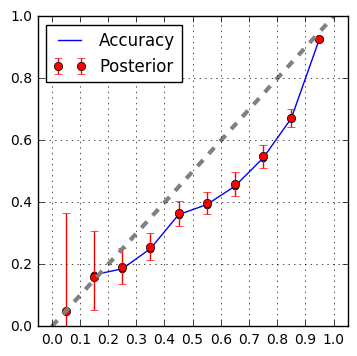

In [140]:
plt.figure(figsize=(4,4))
plt.grid(True)
plt.xticks(range(NUM_BINS+1), ["%.1f" % i for  i in bins])
plt.scatter([i+0.5 for i in range(NUM_BINS)], accuracy_bins)
plt.plot([i+0.5 for i in range(NUM_BINS)],accuracy_bins,label="Accuracy")
plt.errorbar([i+0.5 for i in range(NUM_BINS)],
             BetaPosteriorsMean,
             yerr=(BetaPosteriorsMean-BetaPosteriorP025,BetaPosteriorP975-BetaPosteriorsMean),
             fmt='o', color = 'r',label="Posterior")
plt.plot(np.linspace(0, 1, 11),linestyle="--",linewidth=3,c = "gray")
plt.legend(loc='upper left')
plt.ylim((0.0,1.0))
plt.savefig("figures/reliability_plot_%d"%N)
# plt.xlabel("Confidence")
# plt.ylabel("Accuracy")

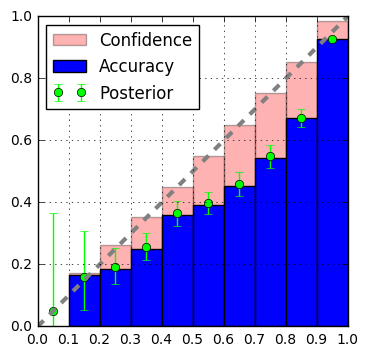

In [141]:
plt.figure(figsize=(4,4))
plt.grid(True)
plt.xticks(range(NUM_BINS+1), ["%.1f" % i for  i in bins])
plt.bar(range(NUM_BINS),confidence_bins,color='r',width=1.0,label="Confidence",alpha=0.3)
plt.bar(range(NUM_BINS),accuracy_bins,color='b',width=1.0,label="Accuracy")
plt.errorbar([i+0.5 for i in range(NUM_BINS)],
             BetaPosteriorsMean,
             yerr=(BetaPosteriorsMean-BetaPosteriorP025,BetaPosteriorP975-BetaPosteriorsMean),
             fmt='o', color = 'lime',label="Posterior")
plt.plot(np.linspace(0, 1, 11),linestyle="--",linewidth=3,c = "gray")
plt.legend(loc='upper left')
plt.savefig("figures/reliability_bar_%d"%N)
# plt.xlabel("Confidence")
# plt.ylabel("Accuracy")

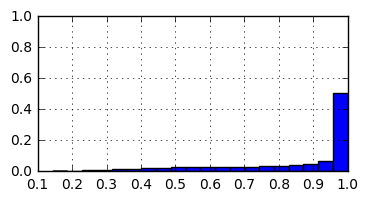

In [142]:
plt.figure(figsize=(4,2))
plt.grid(True)
plt.hist(confidence, weights=np.ones_like(confidence)/float(len(confidence)), bins=20)
plt.ylim((0.0,1.0))
plt.savefig("figures/confidence_hist_%d"%N)
#plt.ylabel("% of Samples")